# **회귀 모델링 실습 1: 단일 층으로 이루어진 회귀 모델**


## **1. 환경준비**

### (1) 라이브러리 Import

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

### (2) device 준비

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


## **2. 데이터 전처리**

### (1) 데이터 로딩 및 준비

In [ ]:
# 데이터 로딩
path = 'https://bit.ly/ds_boston_csv'
data = pd.read_csv(path)

# x, y 분할
target = 'medv'
features = ['lstat', 'ptratio', 'crim']
x = data.loc[:, features]
y = data.loc[:, target]

# train, val 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.2, random_state = 20)

# 스케일러 선언
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (2) 데이터 로더

In [ ]:
# 데이터 로더 함수
def make_DataSet(x_train, x_val, y_train, y_val, batch_size = 32) :
    # 데이터 텐서로 변환
    x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
    x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

    # TensorDataset 생성: 텐서 데이터 세트로 합치기
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)

    # DataLoader 생성
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle = True)

    return train_loader, x_val_tensor, y_val_tensor

In [ ]:
# 데이터프레임을 넘파이 배열로 변환
print(type(y_train), type(y_val))
y_train = y_train.values
y_val = y_val.values
print(type(y_train), type(y_val))

<class 'pandas.core.series.Series'> <class 'pandas.core.series.Series'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
# make_DataSet 함수로 데이터 로더를 구성
train_loader, x_val_ts, y_val_ts = make_DataSet(x_train, x_val, y_train, y_val, 32)

# 첫 번째 배치만 로딩해서 살펴보기
for x, y in train_loader:
    print(f'Shape of x [rows, columns]: {x.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break

Shape of x [rows, columns]: torch.Size([32, 3])
Shape of y: torch.Size([32, 1]) torch.float32


## **3. 모델링 : 모델 구조 설계부터 학습까지**

### (1) 모델 구조 설계

In [ ]:
n_feature = x.shape[1]
model1 = nn.Sequential(nn.Linear(n_feature, 1)).to(device)

loss_fn = nn.MSELoss()
optimizer = Adam(model1.parameters(), lr=0.01)
print(model1)

Sequential(
  (0): Linear(in_features=3, out_features=1, bias=True)
)


### (2) 학습 함수 : train

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    tr_loss = 0
    model.train()
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        loss = loss_fn(pred, y)
        tr_loss += loss
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    tr_loss /= num_batches
    return tr_loss.item()

### (3) 모델 검증 평가 함수: evaluate

In [ ]:
def evaluate(x_val_tensor, y_val_tensor, model, loss_fn, device):
    model.eval()
    with torch.no_grad():
        x, y = x_val_tensor.to(device), y_val_tensor.to(device)
        pred = model(x)
        val_loss = loss_fn(pred, y).item()
    return val_loss, pred

### (4) 학습

In [ ]:
epochs = 50
tr_loss_list, val_loss_list = [], []
for t in range(epochs):
    tr_loss = train(train_loader, model1, loss_fn, optimizer, device)
    val_loss, _ = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
    tr_loss_list.append(tr_loss)
    val_loss_list.append(val_loss)
    print(f'Epoch {t+1}, train loss: {tr_loss:4f}, val loss: {val_loss:4f}')

Epoch 1, train loss: 566.328979, val loss: 492.862122
Epoch 2, train loss: 561.448853, val loss: 482.863159
Epoch 3, train loss: 555.438354, val loss: 472.986511
Epoch 4, train loss: 543.144958, val loss: 463.280029
Epoch 5, train loss: 539.451721, val loss: 453.841034
Epoch 6, train loss: 518.352112, val loss: 444.507111
Epoch 7, train loss: 509.756866, val loss: 435.436462
Epoch 8, train loss: 499.935699, val loss: 426.521667
Epoch 9, train loss: 493.159027, val loss: 417.845154
Epoch 10, train loss: 484.737823, val loss: 409.373810
Epoch 11, train loss: 478.395844, val loss: 401.062378
Epoch 12, train loss: 468.829620, val loss: 392.882385
Epoch 13, train loss: 463.079407, val loss: 384.923706
Epoch 14, train loss: 450.163391, val loss: 377.080383
Epoch 15, train loss: 443.873657, val loss: 369.518463
Epoch 16, train loss: 434.732971, val loss: 361.994476
Epoch 17, train loss: 432.428650, val loss: 354.724487
Epoch 18, train loss: 423.791992, val loss: 347.582642
Epoch 19, train los

### (5) 학습곡선

In [ ]:
# 학습곡선 함수
def dl_learning_curve(tr_loss_list, val_loss_list):
    epochs = list(range(1, len(tr_loss_list)+1))
    plt.plot(epochs, tr_loss_list, label='train_err', marker = '.')
    plt.plot(epochs, val_loss_list, label='val_err', marker = '.')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

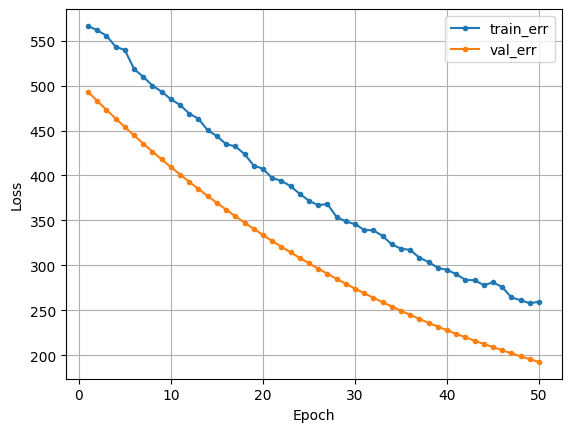

In [ ]:
# 학습 곡선
dl_learning_curve(tr_loss_list, val_loss_list)

### (6) 모델평가

In [ ]:
_, pred = evaluate(x_val_ts, y_val_ts, model1, loss_fn, device)
mae = mean_absolute_error(y_val_ts.numpy(), pred.numpy())
mape = mean_absolute_percentage_error(y_val_ts.numpy(), pred.numpy())
print(f'MAE : {mae}')
print(f'MAPE : {mape}')

MAE : 11.053213119506836
MAPE : 0.47790589928627014
